In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\example_trajectories")

include = [1, 3, 4, 6, 7, 8]

dnt.set_plot_style()
spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)


cycles = [10, 11, 12, 13, 14]
earliest_frames = [25, 48, 43, 63, 80, 30]

['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  35  60 110 160 280] 25 246


reading spots dfs: 2it [00:00,  2.21it/s]

[  0  50  80 140 200 280] 0 283


reading spots dfs: 4it [00:02,  1.95it/s]

[  0  55  90 140 200 350] 0 332


reading spots dfs: 5it [00:03,  1.15it/s]

[  0  65 100 150 225 350] 0 311


reading spots dfs: 7it [00:05,  1.31it/s]

[  0  85 125 170 225 350] 0 325


reading spots dfs: 8it [00:06,  1.08it/s]

[  0  42  65 130 200 350] 0 320


reading spots dfs: 14it [00:08,  1.72it/s]


In [2]:
k = 3

df = spots_dfs[k]
df = df[df["frame"] >= earliest_frames[k]]


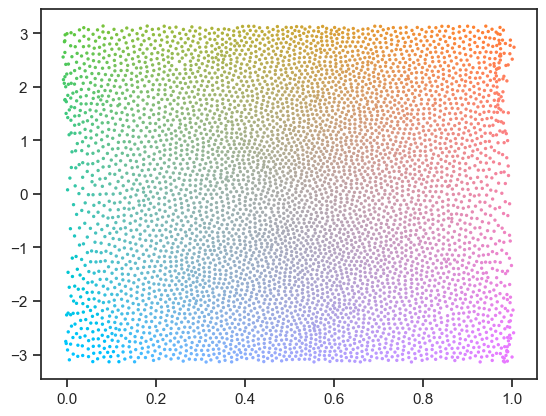

In [3]:
import colorstamps
import napari

frame_df = df[df["frame"] == df["frame"].max()]
colors = colorstamps.apply_stamp(frame_df["AP"].values, frame_df["theta"].values, "flat")[0]

points = frame_df[["z", "y", "x"]].values

plt.scatter(frame_df["AP"], frame_df["theta"], c=colors, s=2)
plt.show()

viewer = napari.Viewer(ndisplay=3)
viewer.add_points(points, size=7, face_color=colors)
napari.run()


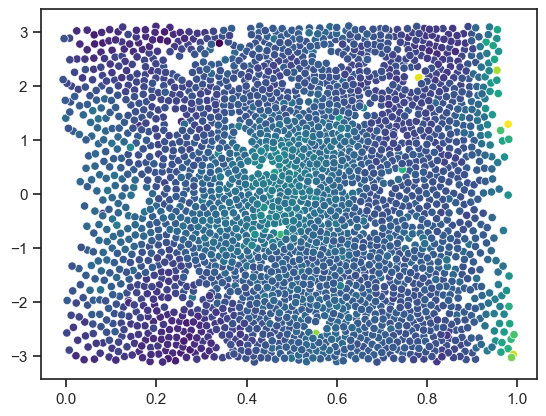

In [4]:
cycle_df = df[df["cycle"] == 13].copy()
cycle_df = cycle_df[cycle_df["distance"] < 4]

t = cycle_df.groupby("tracklet_id")
APs = t["AP"].mean().values
thetas = t["theta"].mean().values
division_times = t["time_since_nc11"].max().values

sns.scatterplot(x=APs, y=thetas, hue=division_times, palette="viridis", legend=None)
plt.show()


In [70]:
k = 0

# Get parent_tracklet
df = spots_dfs[k].copy()
df = df[df["frame"] >= earliest_frames[k]].copy()

division_times_df = dnt.get_division_times(df)

    prev_tracklet_id  time_since_division   distance  cycle  n_points  \
18                23                  0.0   4.652979     11         2   
19                25                  0.0   4.751178     11         2   
20               105                  0.0  17.829874     11         2   
21               106                  0.0  16.036063     11         2   
22               107                  0.0  11.724418     11         2   

    nc11_time           z          y           x        AP     theta  
18  -0.733333  130.099133  83.316130  176.169684  0.149737 -3.048082  
19  -0.733333   90.727186  84.702065  177.023493  0.158376 -2.499833  
20  -0.733333  119.346538  25.767297   95.095860  0.034626 -0.003514  
21  -0.733333   90.059600  35.995943   85.540094  0.058559 -0.727922  
22  -0.733333  115.655713  52.112990   72.144439  0.085633  0.096531  
Cycle 11: [-3.08950986 10.5527042  12.01160976]
x intercepts for cycle 11: [ 4.31638074 -0.90072431]
Cycle 12: [-3.21217706  9.98163311

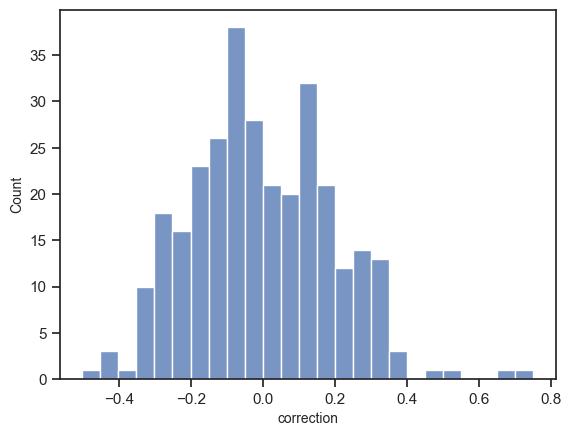

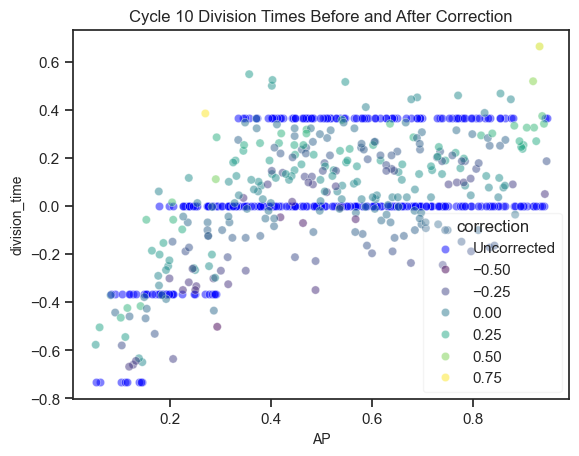

(2500, 8) (2500, 8) (304,)


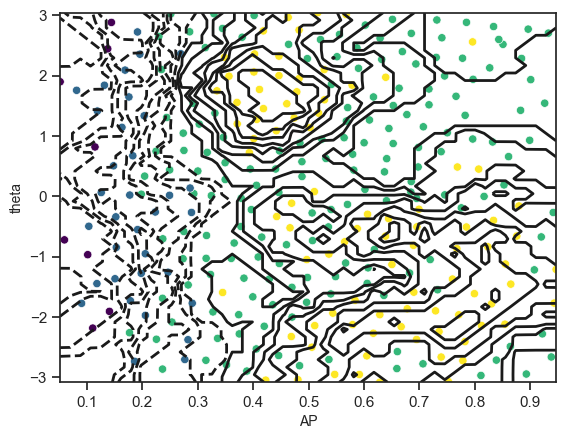

(2500, 8) (2500, 8) (304,)


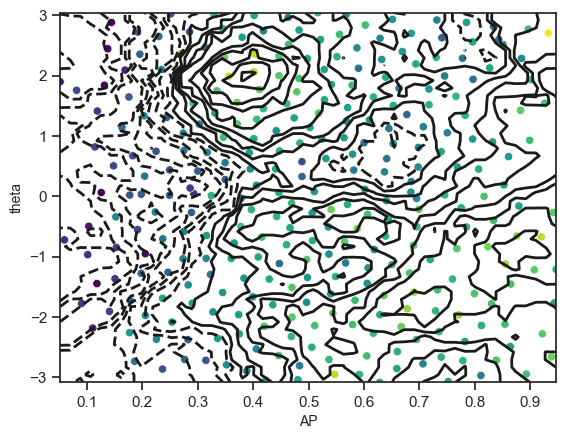

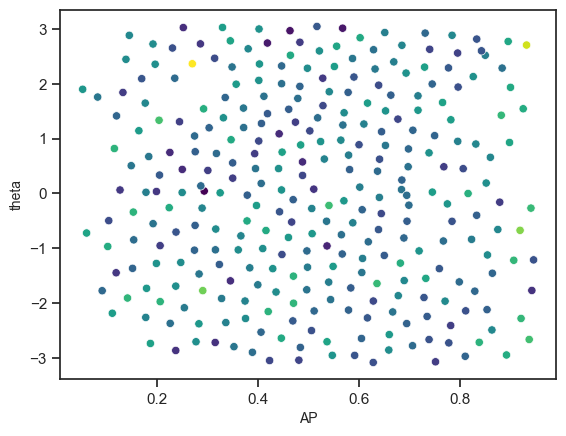

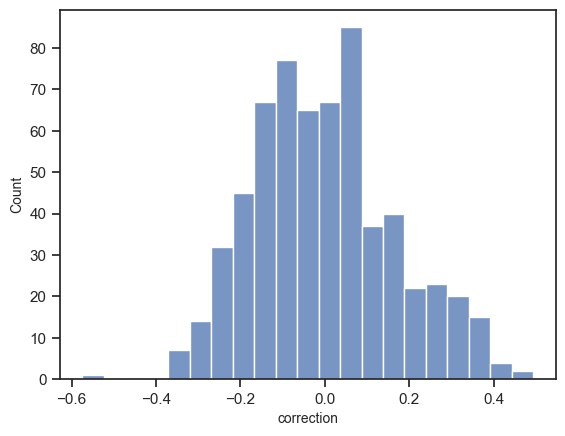

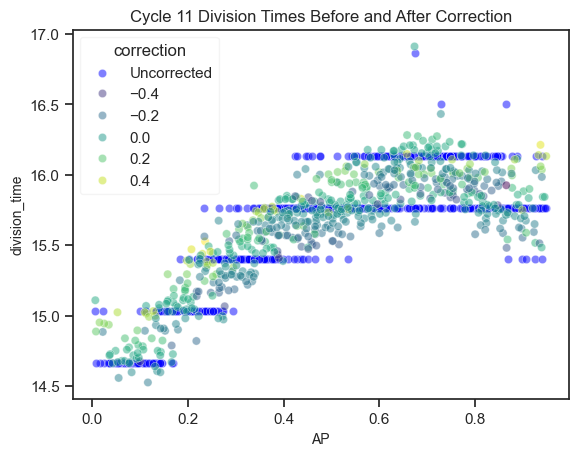

(2500, 8) (2500, 8) (623,)


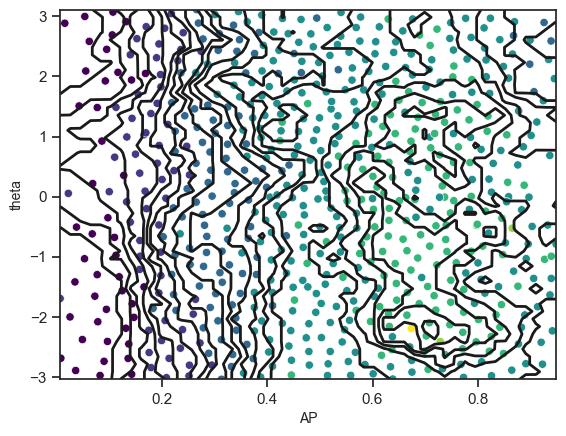

(2500, 8) (2500, 8) (623,)


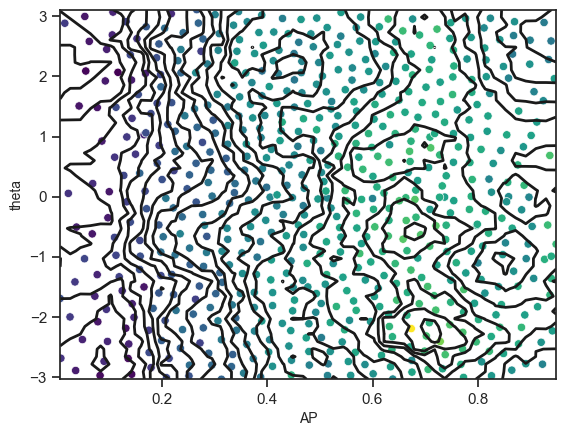

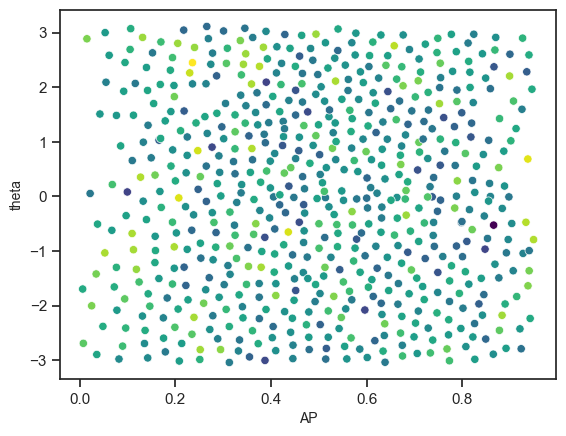

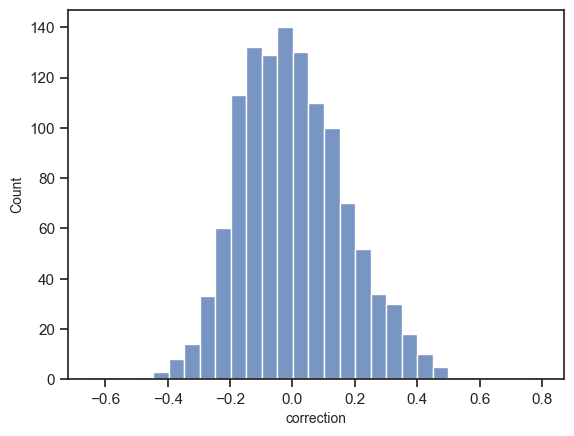

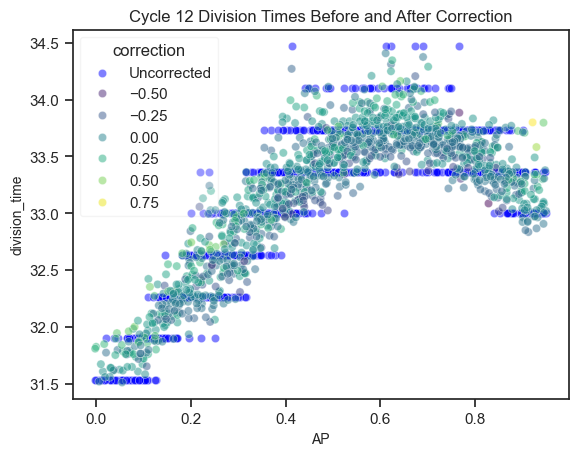

(2500, 8) (2500, 8) (1197,)


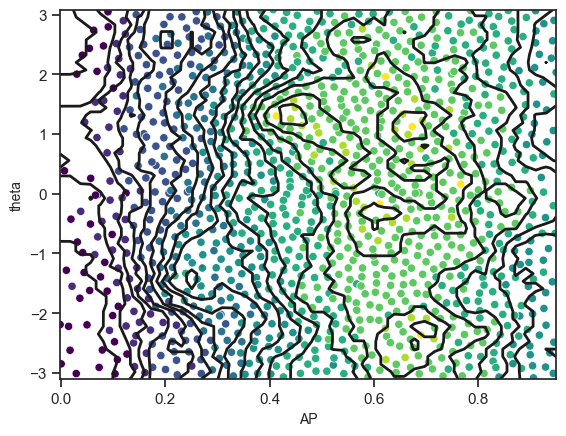

(2500, 8) (2500, 8) (1197,)


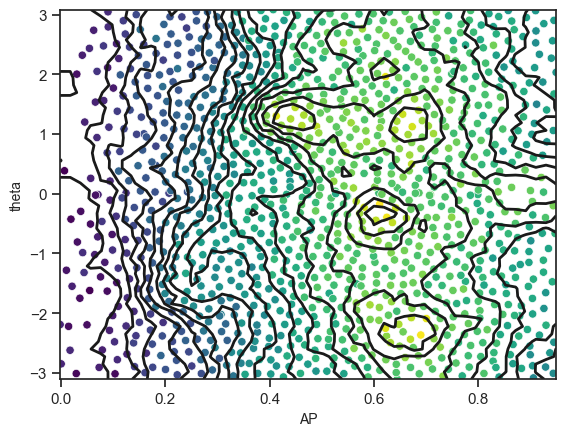

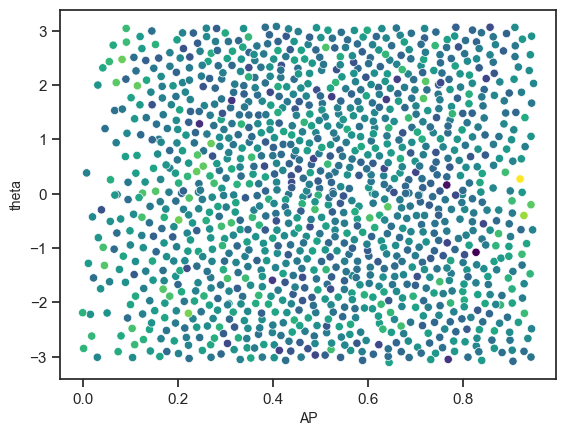

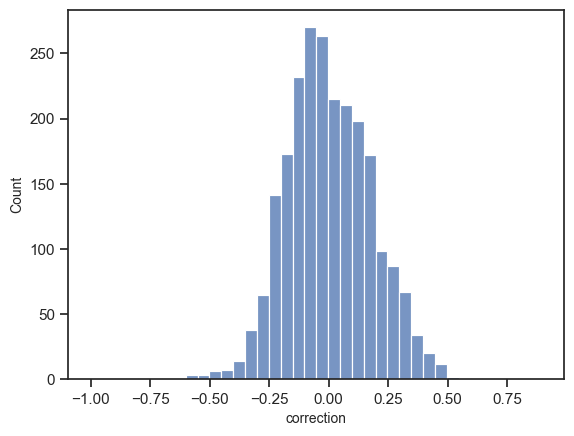

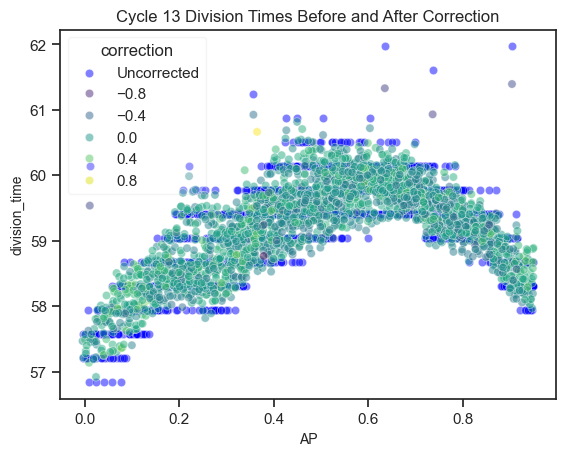

(2500, 8) (2500, 8) (2335,)


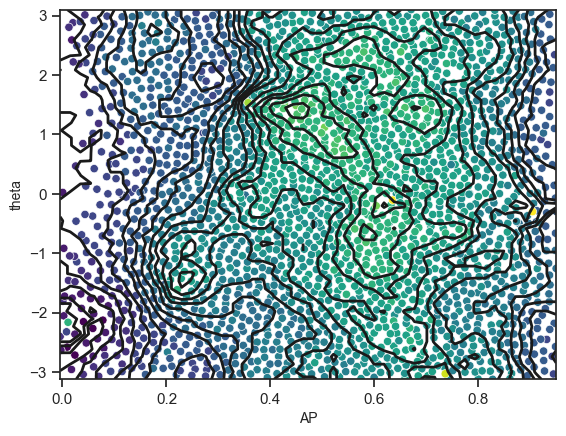

(2500, 8) (2500, 8) (2335,)


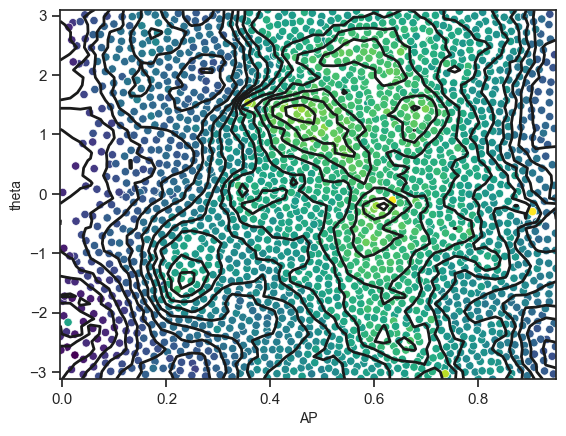

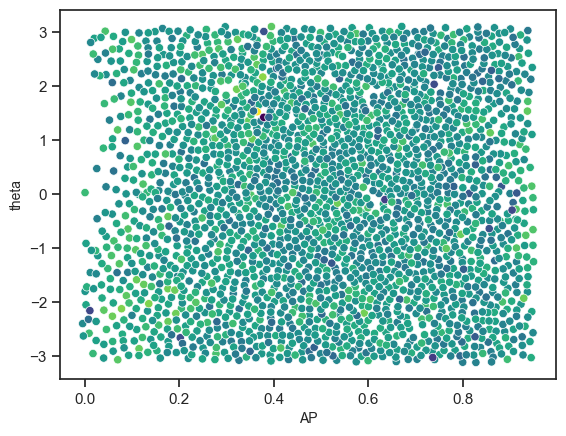

In [73]:
from sklearn.neighbors import KDTree
from scipy.stats import norm

def contour_plot_from_scatter(x, y, z):

    x_rescaled = (x - x.min()) / (x.max() - x.min())
    y_rescaled = (y - y.min()) / (y.max() - y.min())

    tree = KDTree(np.vstack([x_rescaled, y_rescaled]).T)
    grid_x, grid_y = np.mgrid[0:1:50j, 0:1:50j]

    dist, idx = tree.query(np.vstack([grid_x.ravel(), grid_y.ravel()]).T, k=8)
    weights = norm.pdf(dist, scale=0.3)
    print(idx.shape, weights.shape, z.shape)
    z = np.sum(weights * z[idx], axis=1) / np.sum(weights, axis=1)
    z = z.reshape(grid_x.shape)

    grid_x_scaled = grid_x * (x.max() - x.min()) + x.min()
    grid_y_scaled = grid_y * (y.max() - y.min()) + y.min()

    plt.contour(grid_x_scaled, grid_y_scaled, z, levels=20, colors="k", linewidths=2)


for cycle in [10, 11, 12, 13]:
    cycle_df = division_times_df[division_times_df["cycle"] == cycle]
    cycle_df = cycle_df[cycle_df["AP"] < 0.95]
    cycle_df = cycle_df[cycle_df["error"] < 2]
    cycle_df = cycle_df[np.abs(cycle_df["corrected_division_time"] - cycle_df["corrected_division_time"].median()) <= cycle_df["corrected_division_time"].std()*3]
    cycle_df = cycle_df.copy()
    cycle_df["correction"] = cycle_df["corrected_division_time"] - cycle_df["division_time"]

    fake_correction = np.random.choice(cycle_df["correction"].values, size=len(cycle_df), replace=True)
    cycle_df["fake_correction"] = cycle_df["division_time"] + fake_correction

    sns.histplot(cycle_df, x="correction", binwidth=0.05)
    plt.show()

    sns.scatterplot(cycle_df, x="AP", y="division_time", color="blue", label="Uncorrected", alpha=0.5)
    # sns.scatterplot(cycle_df, x="AP", y="corrected_division_time", color="green", label="Corrected", alpha=0.5)
    sns.scatterplot(cycle_df, x="AP", y="corrected_division_time", hue="correction", palette="viridis", alpha=0.5)
    # sns.scatterplot(cycle_df, x="AP", y="fake_correction", color="red", label="Fake Correction", alpha=0.5)
    plt.title(f"Cycle {cycle} Division Times Before and After Correction")
    plt.show()

    sns.scatterplot(cycle_df, x="AP", y="theta", hue="division_time", palette="viridis", legend=False)
    contour_plot_from_scatter(cycle_df["AP"].values, cycle_df["theta"].values, cycle_df["division_time"].values)

    plt.show()
    sns.scatterplot(cycle_df, x="AP", y="theta", hue="corrected_division_time", palette="viridis", legend=False)
    contour_plot_from_scatter(cycle_df["AP"].values, cycle_df["theta"].values, cycle_df["corrected_division_time"].values)
    plt.show()

    sns.scatterplot(cycle_df, x="AP", y="theta", hue="correction", palette="viridis", legend=False)
    plt.show()

Cycle 11: [-3.08950986 10.5527042  12.01160976]
x intercepts for cycle 11: [ 4.31638074 -0.90072431]
Cycle 12: [-3.21217706  9.98163311 10.52710924]
x intercepts for cycle 12: [ 3.93936013 -0.8319246 ]
Cycle 13: [-3.10939502  8.77425559  9.68607747]
x intercepts for cycle 13: [ 3.6705313  -0.84867832]
Cycle 14: [-2.83417141  7.7884765   8.86916758]
x intercepts for cycle 14: [ 3.61397008 -0.86590888]


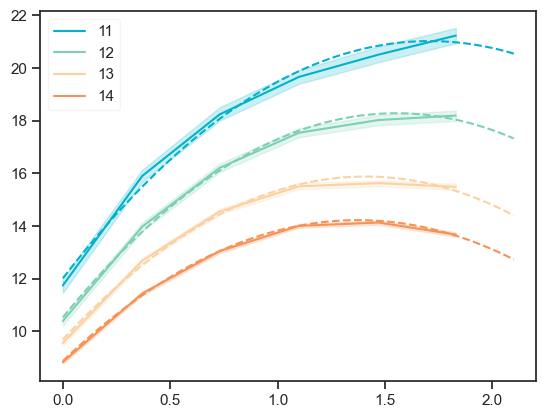

Tracklet 2259 best fit shift: 0.14859437751004
Tracklet 983 best fit shift: 0.0923694779116464
Tracklet 3593 best fit shift: 0.14859437751004
Tracklet 546 best fit shift: 0.3493975903614457
Tracklet 2 best fit shift: 0.03614457831325302
Tracklet 1345 best fit shift: 0.0923694779116464
Tracklet 4528 best fit shift: -0.14056224899598402
Tracklet 2608 best fit shift: 0.06827309236947787
Tracklet 3208 best fit shift: 0.10843373493975883
Tracklet 406 best fit shift: -0.12449799196787159
Tracklet 1397 best fit shift: 0.028112449799196693
Tracklet 497 best fit shift: -0.10040160642570295
Tracklet 1360 best fit shift: 0.285140562248996
Tracklet 3644 best fit shift: 0.028112449799196693
Tracklet 1769 best fit shift: 0.00401606425702794
Tracklet 132 best fit shift: 0.16465863453815244
Tracklet 1102 best fit shift: 0.34136546184738936
Tracklet 2288 best fit shift: -0.2931726907630523
Tracklet 611 best fit shift: 0.3092369477911645
Tracklet 1564 best fit shift: -0.052208835341365556
Tracklet 1891 

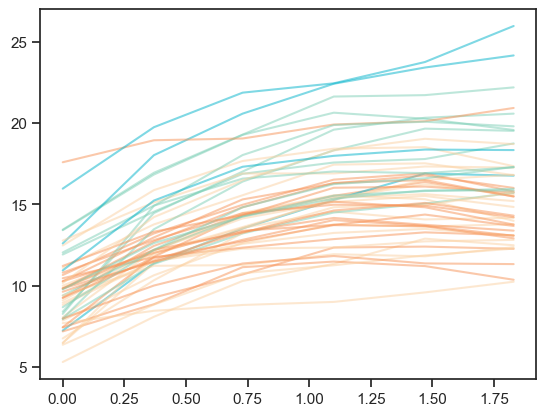

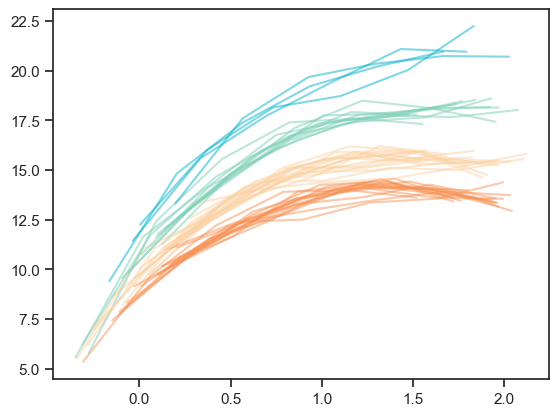

In [32]:
tgb = df.groupby(["frame", "prev_tracklet_id"])
distance = (tgb[["z", "y", "x"]].max() - tgb[["z", "y", "x"]].min()).sum(axis=1).values
time_since = np.round(tgb["time_since_division"].max().values, 2)
cycle = tgb["cycle"].first().values
mask = tgb["z"].count().values == 2
prev_tracklet = tgb["prev_tracklet_id"].first().values

time_since = time_since[mask]
distance = distance[mask]
cycle = cycle[mask]
prev_tracklet = prev_tracklet[mask]

mask = time_since < 2.1

time_since = time_since[mask]
distance = distance[mask]
cycle = cycle[mask]
prev_tracklet = prev_tracklet[mask]

sns.lineplot(x=time_since, y=distance, hue=cycle, palette=dnt.palettes.nc)

cycle_fits = {}

for c in np.unique(cycle):
    cycle_mask = c == cycle
    z = np.polyfit(time_since[cycle_mask], distance[cycle_mask], deg=2)
    print(f"Cycle {c}: {z}")

    x = np.linspace(0, 2.1, 100)
    y = z[0]*x**2 + z[1]*x + z[2]
    plt.plot(x, y, color=dnt.palettes.nc[c], linestyle="--")

    cycle_fits[c] = z

    print(f"x intercepts for cycle {c}: {np.roots(z)}")

plt.show()


# sample 100 tracklets
selected_tracklets = np.random.choice(prev_tracklet, size=50, replace=False)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

def match_quadratic(x, y, z, range_min=-1.0, range_max=1.0, num_points=250):
    x_test = np.linspace(range_min, range_max, num_points)
    x_adj = np.expand_dims(x, 1) - np.expand_dims(x_test, 0)

    y_eval = z[0] * x_adj**2 + z[1] * x_adj + z[2]
    y_error = y_eval - np.expand_dims(y, 1)
    y_corrected = y_error - np.mean(y_error, axis=0)
    best_idx = np.argmin(np.sum(y_corrected**2, axis=0))

    x0 = x_test[best_idx]
    offset = np.mean(z[0] * (x - x0)**2 + z[1] * (x - x0) + z[2] - y)

    return x0, offset

for tracklet in selected_tracklets:
    tracklet_mask = prev_tracklet == tracklet

    distances = distance[tracklet_mask]
    time_sinces = time_since[tracklet_mask]
    this_cycle = cycle[tracklet_mask][0]

    x0, offset = match_quadratic(
        time_sinces, distances, cycle_fits[this_cycle]
    )

    print(f"Tracklet {tracklet} best fit shift: {x0}")

    ax1.plot(time_sinces, distances, color=dnt.palettes.nc[this_cycle], alpha=0.5)
    ax2.plot(time_sinces - x0, distances + offset, color=dnt.palettes.nc[this_cycle], alpha=0.5)

#
# plt.ylim(-3, 3)
plt.show()
